In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from math import factorial

Mounted at /content/drive


In [6]:
# Example Lane Ground Truth. This gt sample will be used.

lane_gt = [
  [
    [0, 499.7117660735243],
    [116.26906117583324, 456.0291303062807],
    [222.41378360091102, 417.0413572616848],
    [382.570747002907, 360.1278272051478],
    [403.55020602923116, 353.18192523021617],
    [458.1251501179798, 335.60454064059326],
    [481.6561649718298, 330.3596758840122]
  ],
  [
    [246.3092029341496, 616.0702054916951],
    [402.447371103318, 433.8372881218873],
    [442.15163191092125, 391.8245283855938],
    [458.7746212185682, 375.9996657407969],
    [476.4109750984273, 360.3229067364777],
    [485.96400011668425, 353.2193753126456],
    [499.68116424546355, 344.15624901327357],
    [513.3003486304659, 337.1588623118665],
    [523.7106964067716, 332.66812405542095]
  ],
  [
    [832.9141413308449, 614.5530613414937],
    [644.991394054129, 438.94835072079655],
    [599.1484410195802, 395.9121090965262],
    [583.980859155954, 379.0434900145493],
    [572.622466636621, 363.5561131538732],
    [569.5038984029782, 357.8859890927045],
    [567.0940956769815, 352.7828774376527],
    [566.3853301693354, 347.8215188841301],
    [566.3853301693354, 343.42717273672434],
    [567.8028611846275, 339.17457969084785],
    [570.3544170121535, 335.2054928480298],
    [575.4575286672052, 329.53536878686106]
  ],
  [
    [968, 482.61821603409754],
    [856.6090644020189, 440.6592979814493],
    [739.8178775646436, 395.86028326975145],
    [703.0754736482705, 381.5715706356064],
    [663.4753272050684, 364.42511547463226],
    [638.5357537402407, 351.91838221383586],
    [631.7886327065959, 347.4880012939966],
    [625.3246912768635, 341.0240598642643],
    [621.5824093964923, 334.2199109908619],
    [619.8813721781416, 328.26628072663476]
  ]
]

In [7]:
# Import the necessary visualizations tools

def draw_line_on_image(image, points, color, thickness=1):
    width, height, _ = image.shape

    # points = sorted(points, key=lambda x: x[1])
    for i in range(len(points)):

        # Old cv2 line structure
        x1 = int(np.round(points[i][0]))
        y1 = int(np.round(points[i][1]))

        point = (x1, y1)

        image = cv2.circle(image, point, color=color, radius=thickness, thickness=-1)

    return image

def draw_lane_gt(image_original, lane_gt, thickness=1):
    color_palette = np.array([
        [  0,   0,   0],
        [180, 200,  30],
        [200, 100,   1],
        [  1, 100, 200],
        [ 30, 200, 180]
    ])

    image = image_original.copy()

    for lane_idx, lane in enumerate(lane_gt):
        color = color_palette[lane_idx + 1]
        color = (int(color[0]), int(color[1]), int(color[2]))
        image = draw_line_on_image(image, lane, color, thickness=thickness)

    return image

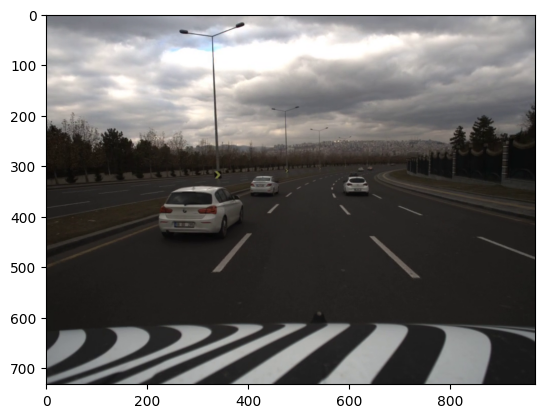

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# Assume the image is uploaded to Colab and named 'track2_01776.png'
image_name = 'track2_01776.png'

# Construct the path to the uploaded image
image_path = '/content/' + image_name

# Open and display the image
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.show()


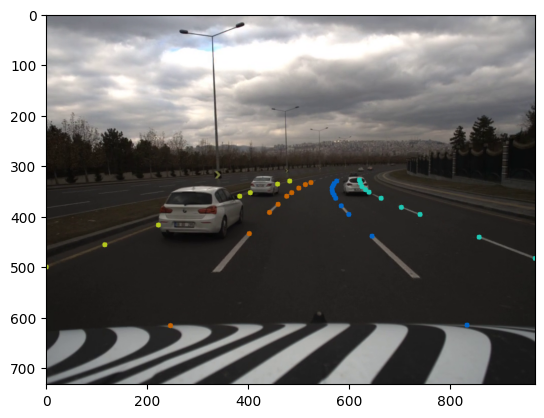

In [20]:
image_with_gt = draw_lane_gt(np.array(image), lane_gt, thickness=5)
plt.imshow(image_with_gt)
plt.show()

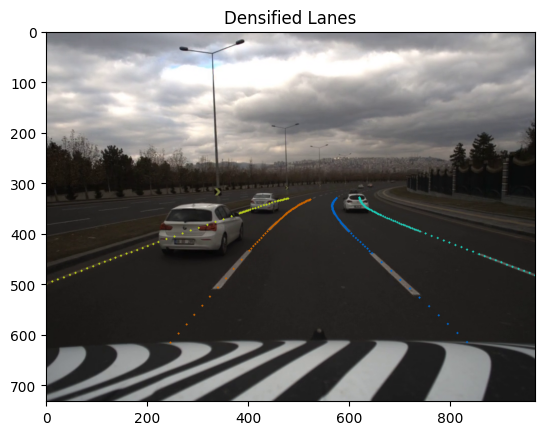

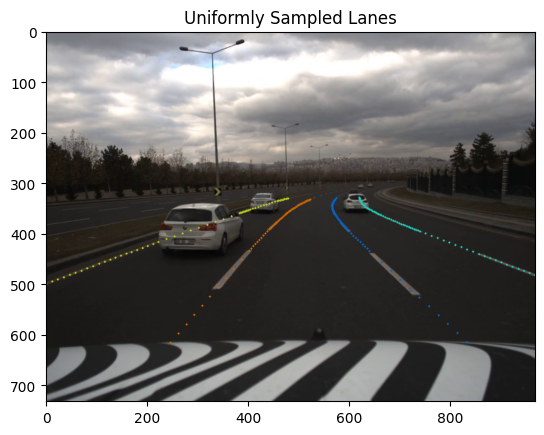

In [21]:
import numpy as np

def piece_wise_sampling(points, num_points):
    '''
    points: list of points
    num_points: number of points to sample between each point in the list

    returns: list of points

    This function aims linear fitting between each point in the list.
    # Hint: use np.polyfit with the first order polynomial
    '''
    new_point_list = []
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        xs = np.linspace(x1, x2, num_points, endpoint=False)
        ys = np.linspace(y1, y2, num_points, endpoint=False)
        new_point_list.extend(list(zip(xs, ys)))
    return new_point_list

def uniform_sampler(points, num_samples):
    '''
    points: list of points
    num_samples: total number of samples

    returns: list of uniformly sampled points

    This function converts the dense representation to uniform representation.
    '''
    indices = np.linspace(0, len(points) - 1, num_samples, dtype=int)
    return [points[i] for i in indices]

# Apply piece-wise sampling to each lane in lane_gt
lane_gt_densified = [piece_wise_sampling(lane, 10) for lane in lane_gt]

# Apply uniform sampling to each densified lane
lane_gt_uniform = [uniform_sampler(lane, 100) for lane in lane_gt_densified]

# Draw the densified and uniformly sampled lanes on the image
image_with_gt_densified = draw_lane_gt(np.array(image), lane_gt_densified, thickness=2)
image_with_gt_uniform = draw_lane_gt(np.array(image), lane_gt_uniform, thickness=2)

# Display the results
plt.imshow(image_with_gt_densified)
plt.title('Densified Lanes')
plt.show()

plt.imshow(image_with_gt_uniform)
plt.title('Uniformly Sampled Lanes')
plt.show()


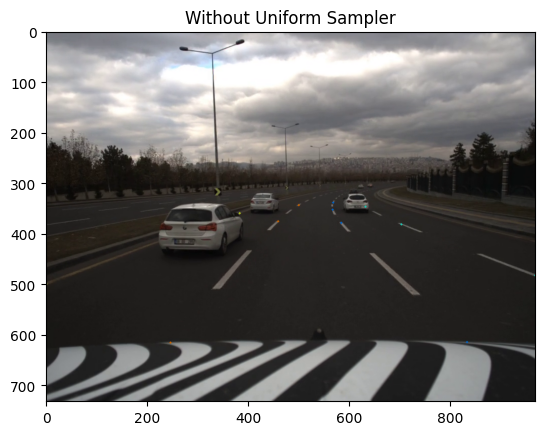

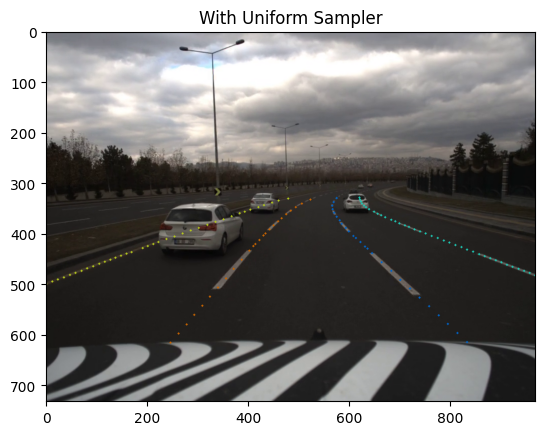

In [22]:
def uniform_sampler(points_densified, num_points=50):
    '''
    points_densified: list of points, output of piece_wise_sampling
    num_points: number of points to sample along the y-axis

    returns: list of points
    # Piece-wise sampling fills the gaps between the points, but the x values are not uniformly sampled along the y-axis
    # Therefore, we need to sample the x values uniformly along the y-axis
    '''
    point_list = []
    y_values = np.linspace(min(points_densified[:, 1]), max(points_densified[:, 1]), num_points)

    for y in y_values:
        # Find the closest point in terms of y-axis
        closest_point = min(points_densified, key=lambda point: abs(point[1] - y))
        point_list.append(closest_point)

    return point_list

# In the same for loop, uniform and non-uniform sampling is applied.
# This part is given to you in order to take it as reference
lane_gt_non_uniform = []
lane_gt_uniform = []
for lane in lane_gt_densified:
    lane = np.array(lane)
    lane_non_uniform = lane[::30]
    lane_uniform = uniform_sampler(lane, num_points=40)
    lane_gt_non_uniform.append(lane_non_uniform)
    lane_gt_uniform.append(lane_uniform)

# Compare the non-uniform and uniform sampling
image_with_gt_non_uniform = draw_lane_gt(np.array(image), lane_gt_non_uniform, thickness=2)
plt.title("Without Uniform Sampler")
plt.imshow(image_with_gt_non_uniform)
plt.show()

image_with_gt_uniform = draw_lane_gt(np.array(image), lane_gt_uniform, thickness=2)
plt.title("With Uniform Sampler")
plt.imshow(image_with_gt_uniform)
plt.show()


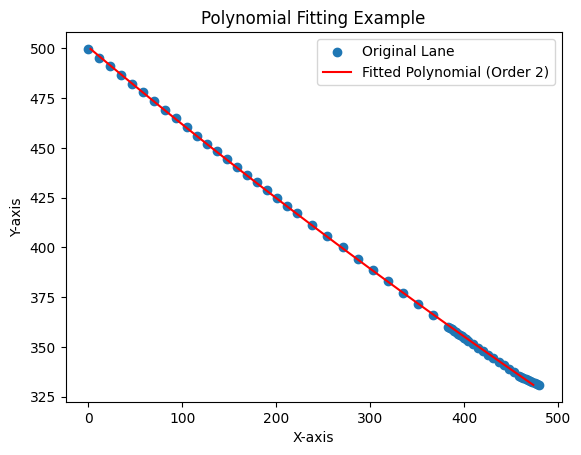

In [24]:
def polynomial_fit_lane(lane_points, order, num_points):
    '''
    lane_points: list of points to be fitted
    order: order of the polynomial
    num_points: number of points to sample along the y-axis

    returns: list of points or numpy array of points which are fitted
    # Hint: you can use np.polyfit with the order of the polynomial
    # Hint: which axis to fit? x or y? Which one is one-to-one mapping?
    '''
    lane_points = np.array(lane_points)
    # Use numpy's polyfit function to fit a polynomial of the given order
    coefficients = np.polyfit(lane_points[:, 1], lane_points[:, 0], order)

    # Generate fitted points along the y-axis
    y_values = np.linspace(min(lane_points[:, 1]), max(lane_points[:, 1]), num_points)

    # Evaluate the polynomial for the fitted y-values
    fitted_x_values = np.polyval(coefficients, y_values)

    # Combine y-values and corresponding fitted x-values
    fitted_points = np.column_stack((fitted_x_values, y_values))

    return fitted_points

# Example usage:
order = 2  # Second order polynomial
num_points = 100
fitted_lane = polynomial_fit_lane(np.array(lane_gt_densified[0]), order, num_points)

# Visualize the original lane and the fitted polynomial
plt.scatter(np.array(lane_gt_densified[0])[:, 0], np.array(lane_gt_densified[0])[:, 1], label='Original Lane')
plt.plot(fitted_lane[:, 0], fitted_lane[:, 1], color='red', label=f'Fitted Polynomial (Order {order})')
plt.legend()
plt.title('Polynomial Fitting Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


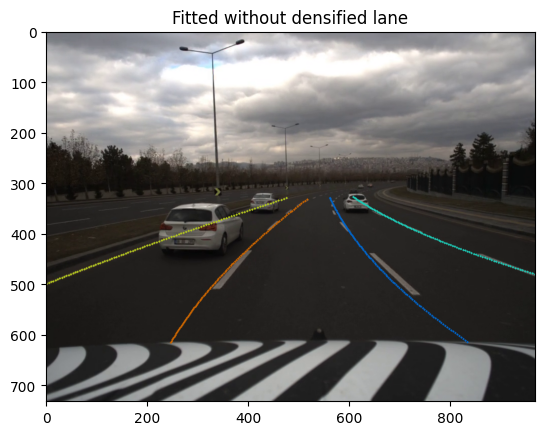

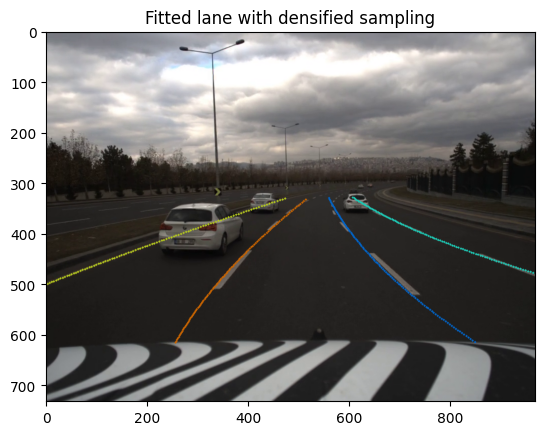

In [25]:
lane_gt_fitted = []
lane_gt_densified_fitted = []

# Fitting polynomials to the original lanes
for lane in lane_gt:
    fitted_lane = polynomial_fit_lane(np.array(lane), order=2, num_points=100)
    lane_gt_fitted.append(fitted_lane)

# Fitting polynomials to the densified lanes
for densified_lane in lane_gt_densified:
    fitted_densified_lane = polynomial_fit_lane(np.array(densified_lane), order=2, num_points=100)
    lane_gt_densified_fitted.append(fitted_densified_lane)

# Visualizing the results
image_with_gt_fitted = draw_lane_gt(np.array(image), lane_gt_fitted, thickness=2)
image_with_gt_densified_fitted = draw_lane_gt(np.array(image), lane_gt_densified_fitted, thickness=2)

plt.imshow(image_with_gt_fitted)
plt.title("Fitted without densified lane")
plt.show()

plt.imshow(image_with_gt_densified_fitted)
plt.title("Fitted lane with densified sampling")
plt.show()



In [28]:
def comb(n, k):
        return factorial(n) // (factorial(k) * factorial(n - k))

# The given class
class CustomParameterizeLane:
    '''
        This class is used to parameterize the lane points with Bezier curve representation
    '''

    def __init__(self, method, method_para):
        method_list = ['bezier_Endpointfixed']
        self.method = method
        if not self.method in method_list:
            raise Exception("Not implemented!")
        self.method_para = method_para

    def __call__(self, lanes):
        lanes_params = getattr(self, self.method)(lanes, **self.method_para)
        return lanes_params

    def fit_bezier(self, points, n_control):
        '''
        points: list of points
        n_control: number of control points

        returns: list of control points
        '''
        points = np.array(points)
        n_points = len(points)
        A = np.zeros((n_points, n_control))
        t = np.arange(n_points) / (n_points - 1)
        for i in range(n_points):
            for j in range(n_control):
                A[i, j] = comb(n_control - 1, j) * np.power(1 - t[i], n_control - 1 - j) * np.power(t[i], j)
        conts = np.linalg.lstsq(A, points, rcond=None)

        control_points = np.zeros((n_control, points.shape[1]))
        control_points = conts[0]
        return control_points

    def bezier_Endpointfixed(self, input_data, n_control=2):
        coeffs_list = []
        for idx, centerline in enumerate(input_data):
            res = self.fit_bezier(centerline, n_control)
            coeffs = res.flatten()
            coeffs_list.append(coeffs)
        return np.array(coeffs_list, dtype=np.float32)

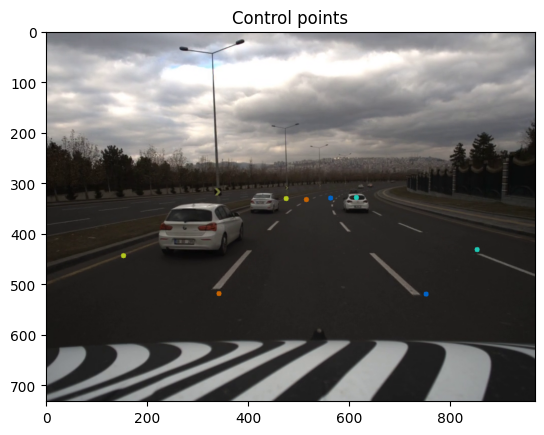

In [31]:
# 4 control points are utilized in this example.
control_points = 4
bezier_fixedpoint = CustomParameterizeLane(method = "bezier_Endpointfixed", method_para = {"n_control": control_points})

bezier_params_uniform = bezier_fixedpoint(lane_gt_uniform)

control_points = bezier_params_uniform.reshape((-1, 2, control_points))

# Visualize the control points
image_with_control_points = draw_lane_gt(np.array(image), control_points, thickness=5)
plt.imshow(image_with_control_points)
plt.title("Control points")
plt.show()

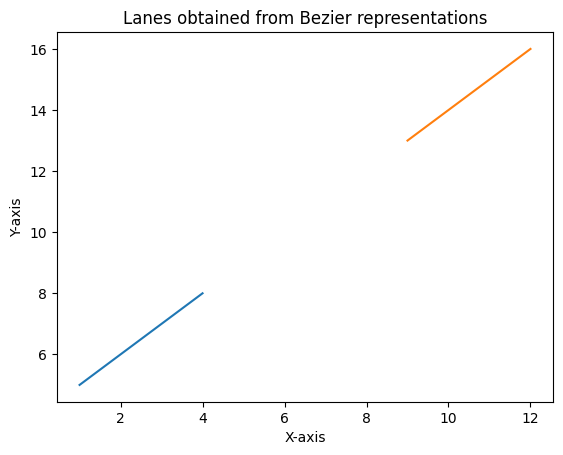

In [32]:
def obtain_lanes_from_bezier_representations(bezier_params, n_points=50):
    '''
    bezier_params: Numpy array of shape (N, 2 * n_control), where N is the number of lanes and n_control is the number of control points
    n_points: number of points to sample along the y-axis to create curve

    returns: list of points or numpy array points which are created from Bezier params (control points)
    '''

    lanes = []
    for bezier_lane_params in bezier_params:
        n_control = len(bezier_lane_params) // 2
        t_values = np.linspace(0, 1, n_points)

        # Initialize an empty array to store the points of the Bezier curve
        bezier_curve = np.zeros((n_points, 2))

        # Calculate Bezier curve points using the given formula
        for i, t in enumerate(t_values):
            x = 0
            y = 0
            for j in range(n_control):
                x += comb(n_control - 1, j) * (1 - t) ** (n_control - 1 - j) * t ** j * bezier_lane_params[j]
                y += comb(n_control - 1, j) * (1 - t) ** (n_control - 1 - j) * t ** j * bezier_lane_params[j + n_control]

            bezier_curve[i] = [x, y]

        lanes.append(bezier_curve)

    return np.array(lanes)

# Example usage:
bezier_params_example = np.array([
    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
    [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
])

lanes_from_bezier = obtain_lanes_from_bezier_representations(bezier_params_example, n_points=100)

# Visualize the obtained lanes from Bezier representations
for lane in lanes_from_bezier:
    plt.plot(lane[:, 0], lane[:, 1])

plt.title("Lanes obtained from Bezier representations")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


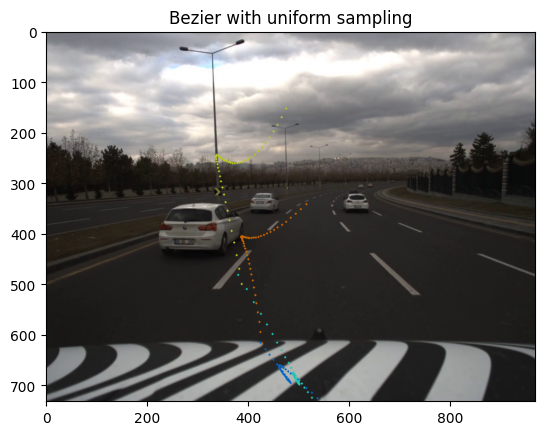

In [33]:
lanes_bezier_uniform = obtain_lanes_from_bezier_representations(bezier_params_uniform, n_points=50)

image_with_bezier_uniform_gt= draw_lane_gt(np.array(image), lanes_bezier_uniform, thickness=2)
plt.title("Bezier with uniform sampling")
plt.imshow(image_with_bezier_uniform_gt)
plt.show()

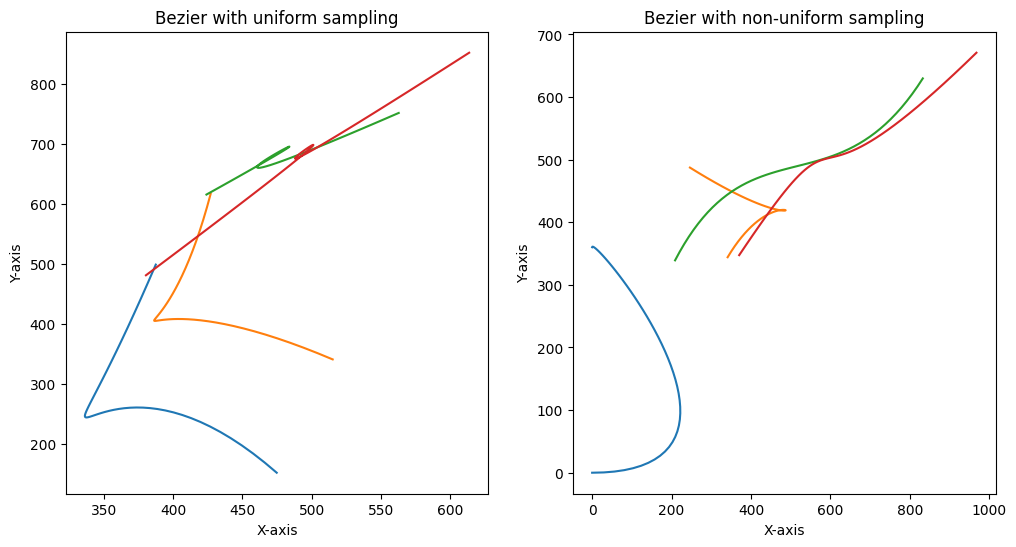

In [34]:
# Obtain Bezier lanes from non-uniform set
lanes_bezier_non_uniform = obtain_lanes_from_bezier_representations(bezier_fixedpoint(lane_gt_non_uniform), n_points=50)

# Visualize the Bezier lanes obtained from uniform and non-uniform sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for lane in lanes_bezier_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
for lane in lanes_bezier_non_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with non-uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()


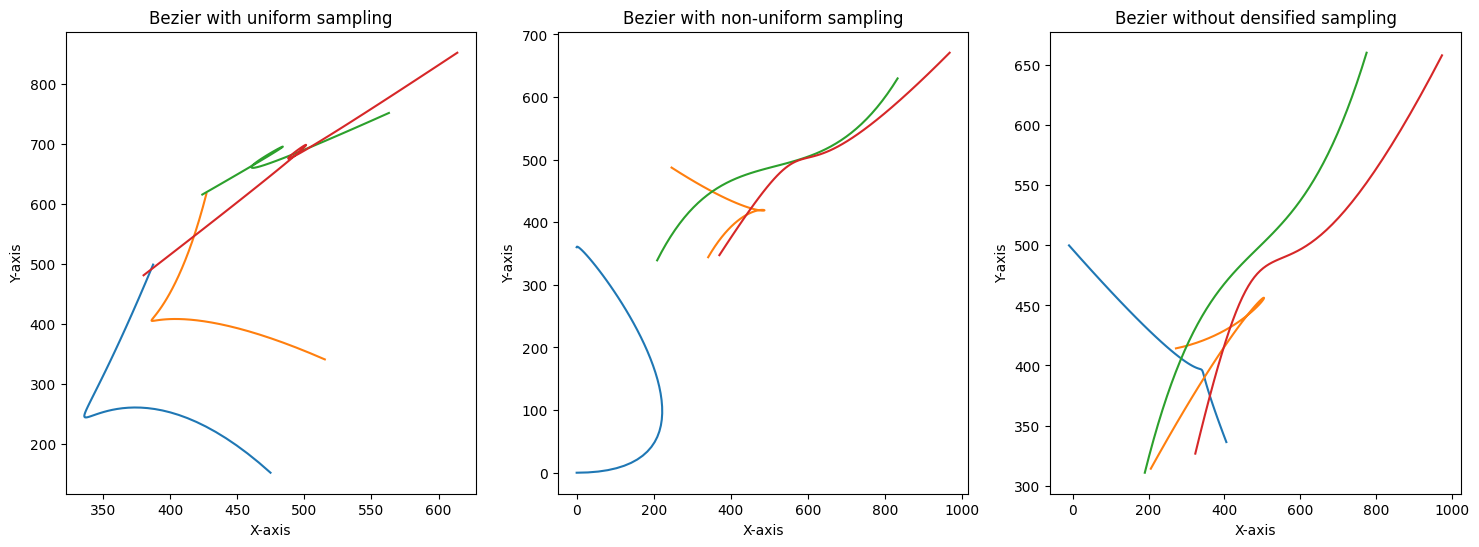

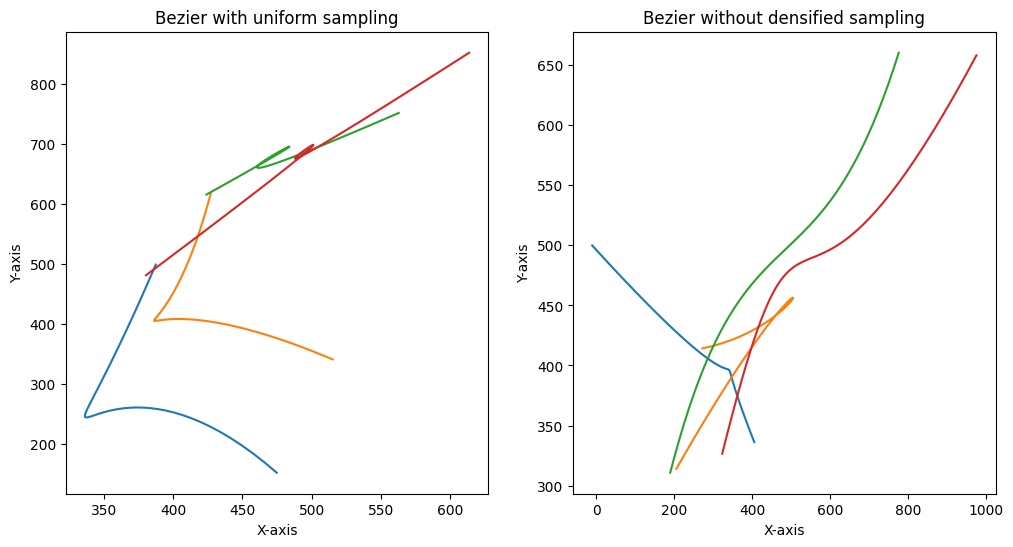

In [35]:
# Obtain Bezier lanes from densified set
lanes_bezier_densified = obtain_lanes_from_bezier_representations(bezier_fixedpoint(lane_gt_densified), n_points=50)

# Visualize the Bezier lanes obtained from uniform, non-uniform, and densified sets
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
for lane in lanes_bezier_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 3, 2)
for lane in lanes_bezier_non_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with non-uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 3, 3)
for lane in lanes_bezier_densified:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier without densified sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()

# Visualize the Bezier lanes obtained from uniform and densified sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for lane in lanes_bezier_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
for lane in lanes_bezier_densified:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier without densified sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()


In [ ]:
# A non-uniform point set can lead to a poor curve
# representation because it lacks enough points
# in certain areas, especially
# where the lane has intricate details or sharp turns.
#  In Bezier curve representation, the positions of control points significantly shape the curve. When points are unevenly spread, there might be gaps or fewer points in critical areas, causing the curve to miss capturing fine details or subtle changes. Consequently, the fitted Bezier curve may not accurately depict the actual shape of the lane in these sparse regions.

# On the other hand, a denser point set, achieved through densification or uniform sampling,
# provides more information for curve fitting. This increased point density allows
# the curve to better adapt to the lane's complex structure, resulting in a more accurate
#  and faithful representation.

# In conclusion, a non-uniform point set may lead to an inaccurate curve representation
#  as it fails to capture necessary details in specific regions of the
#  lane due to a lack of points.

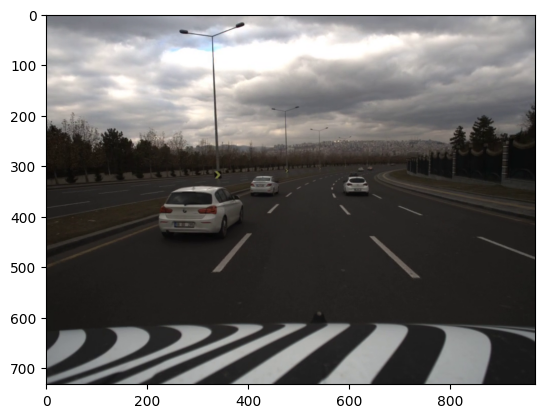

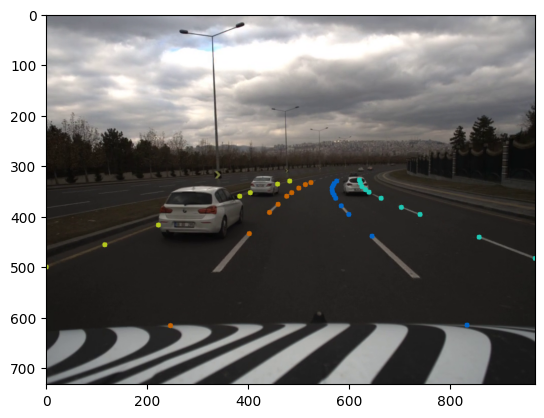

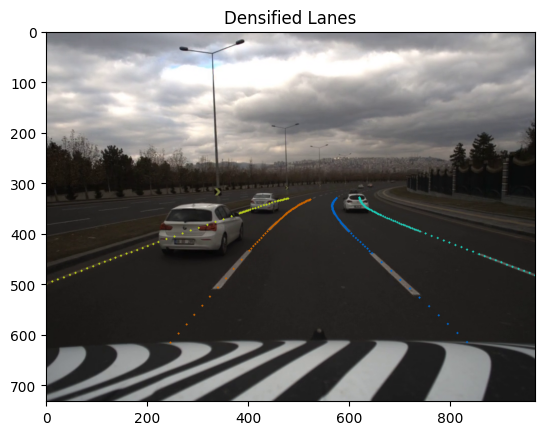

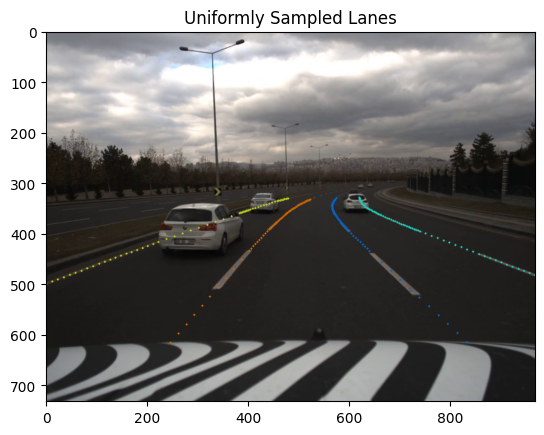

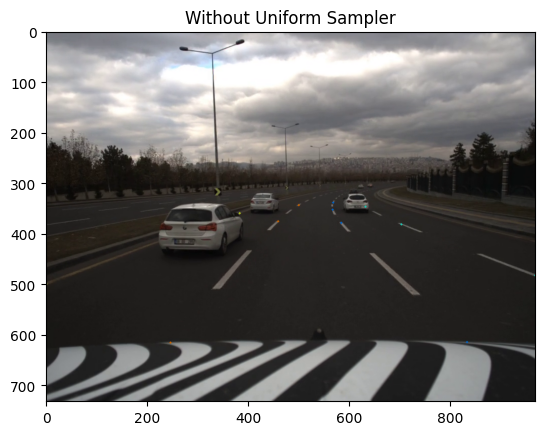

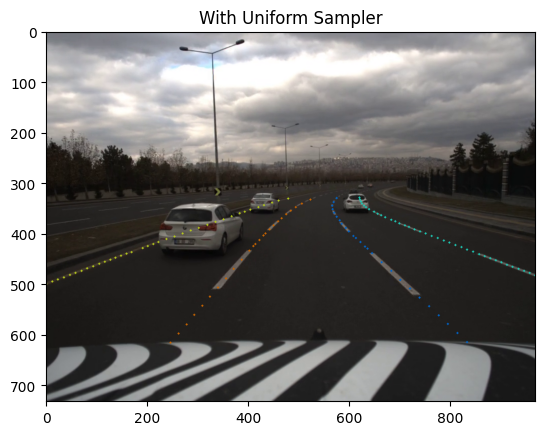

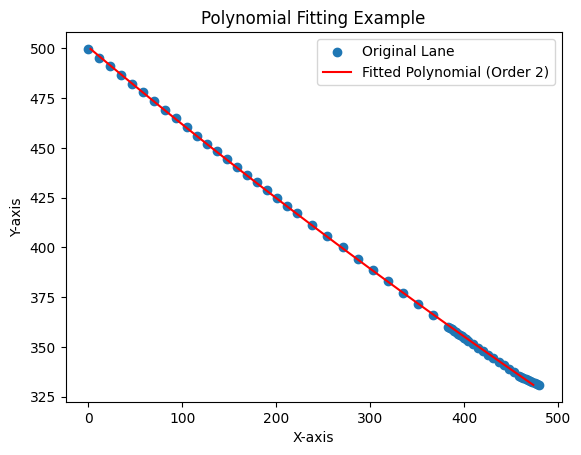

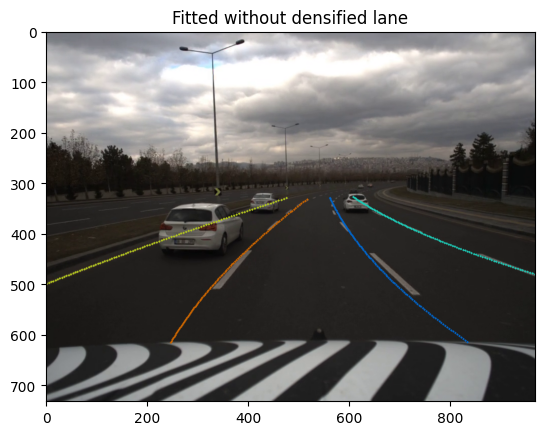

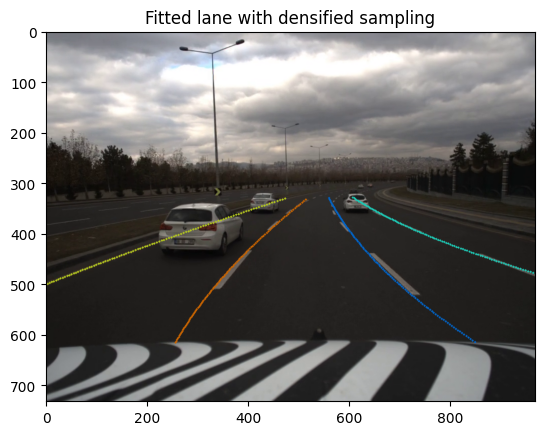

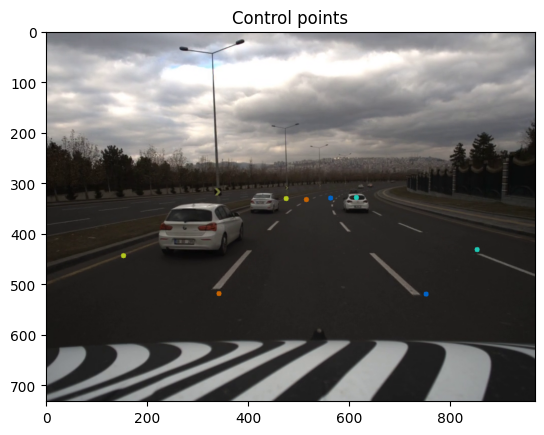

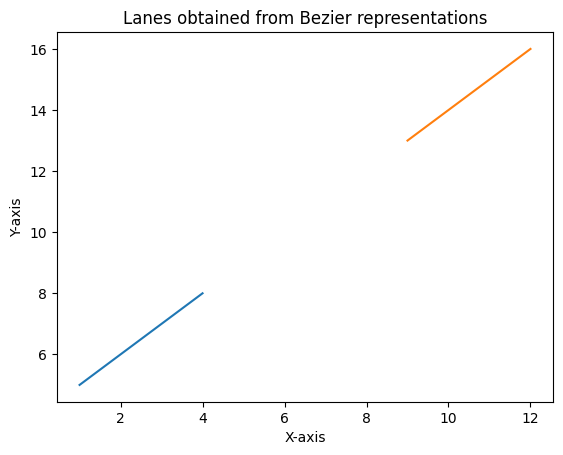

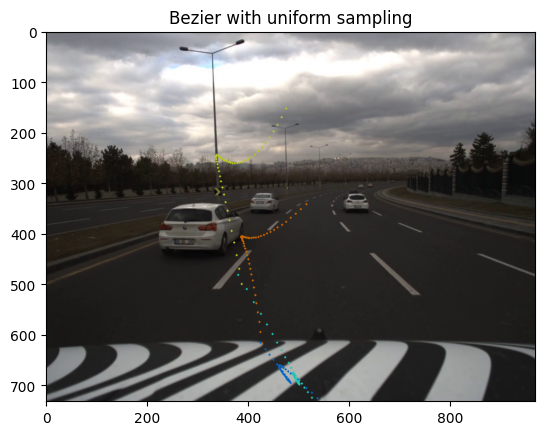

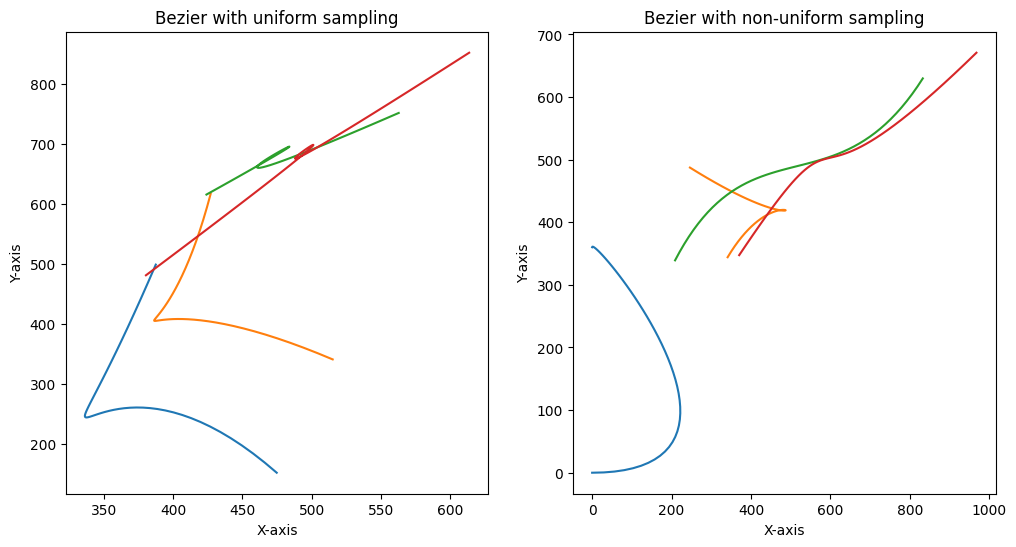

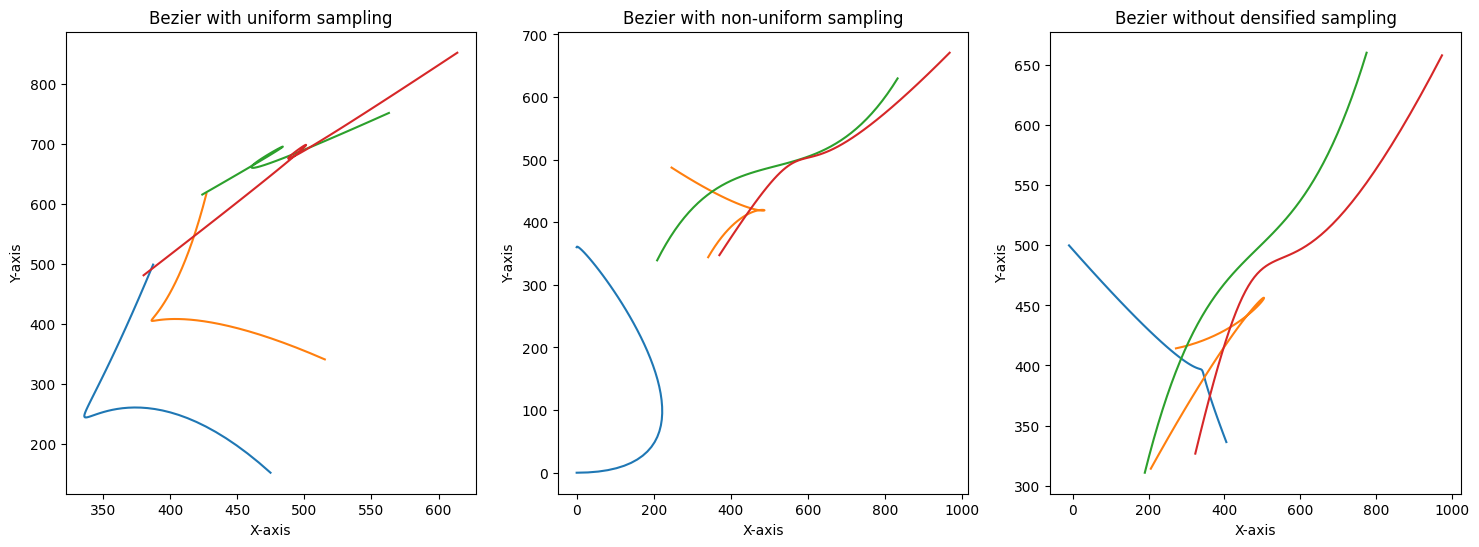

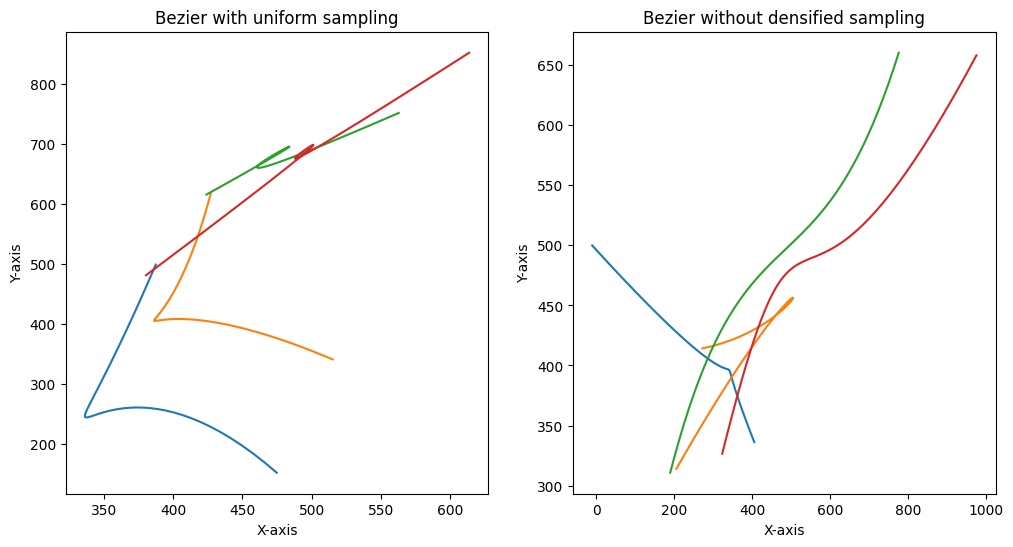

In [38]:
# Example Lane Ground Truth. This gt sample will be used.

lane_gt = [
  [
    [0, 499.7117660735243],
    [116.26906117583324, 456.0291303062807],
    [222.41378360091102, 417.0413572616848],
    [382.570747002907, 360.1278272051478],
    [403.55020602923116, 353.18192523021617],
    [458.1251501179798, 335.60454064059326],
    [481.6561649718298, 330.3596758840122]
  ],
  [
    [246.3092029341496, 616.0702054916951],
    [402.447371103318, 433.8372881218873],
    [442.15163191092125, 391.8245283855938],
    [458.7746212185682, 375.9996657407969],
    [476.4109750984273, 360.3229067364777],
    [485.96400011668425, 353.2193753126456],
    [499.68116424546355, 344.15624901327357],
    [513.3003486304659, 337.1588623118665],
    [523.7106964067716, 332.66812405542095]
  ],
  [
    [832.9141413308449, 614.5530613414937],
    [644.991394054129, 438.94835072079655],
    [599.1484410195802, 395.9121090965262],
    [583.980859155954, 379.0434900145493],
    [572.622466636621, 363.5561131538732],
    [569.5038984029782, 357.8859890927045],
    [567.0940956769815, 352.7828774376527],
    [566.3853301693354, 347.8215188841301],
    [566.3853301693354, 343.42717273672434],
    [567.8028611846275, 339.17457969084785],
    [570.3544170121535, 335.2054928480298],
    [575.4575286672052, 329.53536878686106]
  ],
  [
    [968, 482.61821603409754],
    [856.6090644020189, 440.6592979814493],
    [739.8178775646436, 395.86028326975145],
    [703.0754736482705, 381.5715706356064],
    [663.4753272050684, 364.42511547463226],
    [638.5357537402407, 351.91838221383586],
    [631.7886327065959, 347.4880012939966],
    [625.3246912768635, 341.0240598642643],
    [621.5824093964923, 334.2199109908619],
    [619.8813721781416, 328.26628072663476]
  ]
]
# Import the necessary visualizations tools

def draw_line_on_image(image, points, color, thickness=1):
    width, height, _ = image.shape

    # points = sorted(points, key=lambda x: x[1])
    for i in range(len(points)):

        # Old cv2 line structure
        x1 = int(np.round(points[i][0]))
        y1 = int(np.round(points[i][1]))

        point = (x1, y1)

        image = cv2.circle(image, point, color=color, radius=thickness, thickness=-1)

    return image

def draw_lane_gt(image_original, lane_gt, thickness=1):
    color_palette = np.array([
        [  0,   0,   0],
        [180, 200,  30],
        [200, 100,   1],
        [  1, 100, 200],
        [ 30, 200, 180]
    ])

    image = image_original.copy()

    for lane_idx, lane in enumerate(lane_gt):
        color = color_palette[lane_idx + 1]
        color = (int(color[0]), int(color[1]), int(color[2]))
        image = draw_line_on_image(image, lane, color, thickness=thickness)

    return image

from PIL import Image
import matplotlib.pyplot as plt

# Assume the image is uploaded to Colab and named 'track2_01776.png'
image_name = 'track2_01776.png'

# Construct the path to the uploaded image
image_path = '/content/' + image_name

# Open and display the image
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.show()
image_with_gt = draw_lane_gt(np.array(image), lane_gt, thickness=5)
plt.imshow(image_with_gt)
plt.show()
import numpy as np

def piece_wise_sampling(points, num_points):
    '''
    points: list of points
    num_points: number of points to sample between each point in the list

    returns: list of points

    This function aims linear fitting between each point in the list.
    # Hint: use np.polyfit with the first order polynomial
    '''
    new_point_list = []
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        xs = np.linspace(x1, x2, num_points, endpoint=False)
        ys = np.linspace(y1, y2, num_points, endpoint=False)
        new_point_list.extend(list(zip(xs, ys)))
    return new_point_list

def uniform_sampler(points, num_samples):
    '''
    points: list of points
    num_samples: total number of samples

    returns: list of uniformly sampled points

    This function converts the dense representation to uniform representation.
    '''
    indices = np.linspace(0, len(points) - 1, num_samples, dtype=int)
    return [points[i] for i in indices]

# Apply piece-wise sampling to each lane in lane_gt
lane_gt_densified = [piece_wise_sampling(lane, 10) for lane in lane_gt]

# Apply uniform sampling to each densified lane
lane_gt_uniform = [uniform_sampler(lane, 100) for lane in lane_gt_densified]

# Draw the densified and uniformly sampled lanes on the image
image_with_gt_densified = draw_lane_gt(np.array(image), lane_gt_densified, thickness=2)
image_with_gt_uniform = draw_lane_gt(np.array(image), lane_gt_uniform, thickness=2)

# Display the results
plt.imshow(image_with_gt_densified)
plt.title('Densified Lanes')
plt.show()

plt.imshow(image_with_gt_uniform)
plt.title('Uniformly Sampled Lanes')
plt.show()
def uniform_sampler(points_densified, num_points=50):
    '''
    points_densified: list of points, output of piece_wise_sampling
    num_points: number of points to sample along the y-axis

    returns: list of points
    # Piece-wise sampling fills the gaps between the points, but the x values are not uniformly sampled along the y-axis
    # Therefore, we need to sample the x values uniformly along the y-axis
    '''
    point_list = []
    y_values = np.linspace(min(points_densified[:, 1]), max(points_densified[:, 1]), num_points)

    for y in y_values:
        # Find the closest point in terms of y-axis
        closest_point = min(points_densified, key=lambda point: abs(point[1] - y))
        point_list.append(closest_point)

    return point_list

# In the same for loop, uniform and non-uniform sampling is applied.
# This part is given to you in order to take it as reference
lane_gt_non_uniform = []
lane_gt_uniform = []
for lane in lane_gt_densified:
    lane = np.array(lane)
    lane_non_uniform = lane[::30]
    lane_uniform = uniform_sampler(lane, num_points=40)
    lane_gt_non_uniform.append(lane_non_uniform)
    lane_gt_uniform.append(lane_uniform)

# Compare the non-uniform and uniform sampling
image_with_gt_non_uniform = draw_lane_gt(np.array(image), lane_gt_non_uniform, thickness=2)
plt.title("Without Uniform Sampler")
plt.imshow(image_with_gt_non_uniform)
plt.show()

image_with_gt_uniform = draw_lane_gt(np.array(image), lane_gt_uniform, thickness=2)
plt.title("With Uniform Sampler")
plt.imshow(image_with_gt_uniform)
plt.show()
def polynomial_fit_lane(lane_points, order, num_points):
    '''
    lane_points: list of points to be fitted
    order: order of the polynomial
    num_points: number of points to sample along the y-axis

    returns: list of points or numpy array of points which are fitted
    # Hint: you can use np.polyfit with the order of the polynomial
    # Hint: which axis to fit? x or y? Which one is one-to-one mapping?
    '''
    lane_points = np.array(lane_points)
    # Use numpy's polyfit function to fit a polynomial of the given order
    coefficients = np.polyfit(lane_points[:, 1], lane_points[:, 0], order)

    # Generate fitted points along the y-axis
    y_values = np.linspace(min(lane_points[:, 1]), max(lane_points[:, 1]), num_points)

    # Evaluate the polynomial for the fitted y-values
    fitted_x_values = np.polyval(coefficients, y_values)

    # Combine y-values and corresponding fitted x-values
    fitted_points = np.column_stack((fitted_x_values, y_values))

    return fitted_points

# Example usage:
order = 2  # Second order polynomial
num_points = 100
fitted_lane = polynomial_fit_lane(np.array(lane_gt_densified[0]), order, num_points)

# Visualize the original lane and the fitted polynomial
plt.scatter(np.array(lane_gt_densified[0])[:, 0], np.array(lane_gt_densified[0])[:, 1], label='Original Lane')
plt.plot(fitted_lane[:, 0], fitted_lane[:, 1], color='red', label=f'Fitted Polynomial (Order {order})')
plt.legend()
plt.title('Polynomial Fitting Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
lane_gt_fitted = []
lane_gt_densified_fitted = []

# Fitting polynomials to the original lanes
for lane in lane_gt:
    fitted_lane = polynomial_fit_lane(np.array(lane), order=2, num_points=100)
    lane_gt_fitted.append(fitted_lane)

# Fitting polynomials to the densified lanes
for densified_lane in lane_gt_densified:
    fitted_densified_lane = polynomial_fit_lane(np.array(densified_lane), order=2, num_points=100)
    lane_gt_densified_fitted.append(fitted_densified_lane)

# Visualizing the results
image_with_gt_fitted = draw_lane_gt(np.array(image), lane_gt_fitted, thickness=2)
image_with_gt_densified_fitted = draw_lane_gt(np.array(image), lane_gt_densified_fitted, thickness=2)

plt.imshow(image_with_gt_fitted)
plt.title("Fitted without densified lane")
plt.show()

plt.imshow(image_with_gt_densified_fitted)
plt.title("Fitted lane with densified sampling")
plt.show()
def comb(n, k):
        return factorial(n) // (factorial(k) * factorial(n - k))

# The given class
class CustomParameterizeLane:
    '''
        This class is used to parameterize the lane points with Bezier curve representation
    '''

    def __init__(self, method, method_para):
        method_list = ['bezier_Endpointfixed']
        self.method = method
        if not self.method in method_list:
            raise Exception("Not implemented!")
        self.method_para = method_para

    def __call__(self, lanes):
        lanes_params = getattr(self, self.method)(lanes, **self.method_para)
        return lanes_params

    def fit_bezier(self, points, n_control):
        '''
        points: list of points
        n_control: number of control points

        returns: list of control points
        '''
        points = np.array(points)
        n_points = len(points)
        A = np.zeros((n_points, n_control))
        t = np.arange(n_points) / (n_points - 1)
        for i in range(n_points):
            for j in range(n_control):
                A[i, j] = comb(n_control - 1, j) * np.power(1 - t[i], n_control - 1 - j) * np.power(t[i], j)
        conts = np.linalg.lstsq(A, points, rcond=None)

        control_points = np.zeros((n_control, points.shape[1]))
        control_points = conts[0]
        return control_points

    def bezier_Endpointfixed(self, input_data, n_control=2):
        coeffs_list = []
        for idx, centerline in enumerate(input_data):
            res = self.fit_bezier(centerline, n_control)
            coeffs = res.flatten()
            coeffs_list.append(coeffs)
        return np.array(coeffs_list, dtype=np.float32)
# 4 control points are utilized in this example.
control_points = 4
bezier_fixedpoint = CustomParameterizeLane(method = "bezier_Endpointfixed", method_para = {"n_control": control_points})

bezier_params_uniform = bezier_fixedpoint(lane_gt_uniform)

control_points = bezier_params_uniform.reshape((-1, 2, control_points))

# Visualize the control points
image_with_control_points = draw_lane_gt(np.array(image), control_points, thickness=5)
plt.imshow(image_with_control_points)
plt.title("Control points")
plt.show()
def obtain_lanes_from_bezier_representations(bezier_params, n_points=50):
    '''
    bezier_params: Numpy array of shape (N, 2 * n_control), where N is the number of lanes and n_control is the number of control points
    n_points: number of points to sample along the y-axis to create curve

    returns: list of points or numpy array points which are created from Bezier params (control points)
    '''

    lanes = []
    for bezier_lane_params in bezier_params:
        n_control = len(bezier_lane_params) // 2
        t_values = np.linspace(0, 1, n_points)

        # Initialize an empty array to store the points of the Bezier curve
        bezier_curve = np.zeros((n_points, 2))

        # Calculate Bezier curve points using the given formula
        for i, t in enumerate(t_values):
            x = 0
            y = 0
            for j in range(n_control):
                x += comb(n_control - 1, j) * (1 - t) ** (n_control - 1 - j) * t ** j * bezier_lane_params[j]
                y += comb(n_control - 1, j) * (1 - t) ** (n_control - 1 - j) * t ** j * bezier_lane_params[j + n_control]

            bezier_curve[i] = [x, y]

        lanes.append(bezier_curve)

    return np.array(lanes)

# Example usage:
bezier_params_example = np.array([
    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
    [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
])

lanes_from_bezier = obtain_lanes_from_bezier_representations(bezier_params_example, n_points=100)

# Visualize the obtained lanes from Bezier representations
for lane in lanes_from_bezier:
    plt.plot(lane[:, 0], lane[:, 1])

plt.title("Lanes obtained from Bezier representations")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()
lanes_bezier_uniform = obtain_lanes_from_bezier_representations(bezier_params_uniform, n_points=50)

image_with_bezier_uniform_gt= draw_lane_gt(np.array(image), lanes_bezier_uniform, thickness=2)
plt.title("Bezier with uniform sampling")
plt.imshow(image_with_bezier_uniform_gt)
plt.show()
# Obtain Bezier lanes from non-uniform set
lanes_bezier_non_uniform = obtain_lanes_from_bezier_representations(bezier_fixedpoint(lane_gt_non_uniform), n_points=50)

# Visualize the Bezier lanes obtained from uniform and non-uniform sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for lane in lanes_bezier_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
for lane in lanes_bezier_non_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with non-uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()
# Obtain Bezier lanes from densified set
lanes_bezier_densified = obtain_lanes_from_bezier_representations(bezier_fixedpoint(lane_gt_densified), n_points=50)

# Visualize the Bezier lanes obtained from uniform, non-uniform, and densified sets
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
for lane in lanes_bezier_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 3, 2)
for lane in lanes_bezier_non_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with non-uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 3, 3)
for lane in lanes_bezier_densified:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier without densified sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()

# Visualize the Bezier lanes obtained from uniform and densified sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for lane in lanes_bezier_uniform:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier with uniform sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
for lane in lanes_bezier_densified:
    plt.plot(lane[:, 0], lane[:, 1])
plt.title("Bezier without densified sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.show()
